In [3]:
import numpy as np
import matplotlib.pyplot as plt
import histlite
from tqdm.notebook import tqdm

import sys
sys.path.append('/p/lustre1/yu47/Sterile_Neutrino/sensitivity/')

from neutrino_source import neutrino_source
from detector import detector
from MC_generator import MC_generator

from oscillation import *

In [4]:
source = neutrino_source('Cr51', 1e5, [0.75], [0.9])
det = detector('nEXO')

det.position = (0, 0, 0)
dist = 0.1 # unit: m
source.position = (0, 0, -det.height/2-dist)

#det.baseline = np.sqrt((source.position[0]-det.position[0])**2 + (source.position[1]-det.position[1])**2 + (source.position[2]-det.position[2])**2 )
det.run_time = 100 # days


Emin, Emax, Estep = 0.3, 1.0, 0.01 # unit: MeV
bins = np.arange(Emin, Emax, Estep)
dm2 = 1 # unit: eV
sin2theta_square = 0.1



gen = MC_generator(source, det, bins, dm2, sin2theta_square)
gen.scale_counts()

print(f'Total neutrino events expected is {gen.n_events:.2f} during {det.run_time:d} days running in nEXO (baseline {det.baseline:.2f} m -> from detector center to the source).')


A Cr51 hot neutrino source with nominal 100000.0 in xx years with neutrino energies [0.75] and branch ratios [0.9] is created.
Total neutrino events expected is 4590.70 during 100 days running in nEXO (baseline 1.00 m -> from detector center to the source).


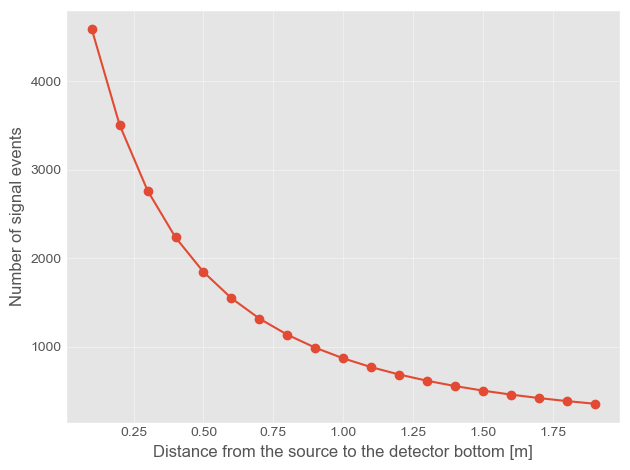

In [9]:
plt.style.use('ggplot')
nevents = []
for dist in np.arange(0.1, 2.0, 0.1):
    gen.source.position = (0, 0, -gen.det.height/2.-dist)
    nevents.append( gen.scale_counts() )

plt.plot(np.arange(0.1, 2.0, 0.1) , nevents, 'o-')
plt.xlabel('Distance from the source to the detector bottom [m]')
plt.ylabel('Number of signal events')
plt.grid(alpha=0.4)
plt.tight_layout()

plt.savefig('../plots/expected_nevents_vs_distance.png')

In [5]:
### Generate non-oscillating Asimov dataset
Enu = gen.source.energies[0]

gen.source.position = (0, 0, -gen.det.height/2.-0.10)
gen.scale_counts()
#gen.n_events = 1e6
print(gen.n_events)

blmin, blmax, blstep = 0.0, 1.5, 0.03
nbins = int((blmax - blmin) / blstep)
L_over_E_min, L_over_E_max = blmin/Enu, blmax/Enu

gen.dm2 = 1.0
gen.sin2theta_square = 0.1
Y = []
for ievt in tqdm(range(5000), desc='Sampling 5000 events for non-oscillating Asimov dataset'):
    nu_pos, bl = gen.generate_nonoscillate_Asimov_dataset()
    

    L_over_E = bl / Enu # unit: m / MeV
    conts, edges = np.histogram(L_over_E, bins=nbins, range=(L_over_E_min, L_over_E_max),)
    cents = (edges[:-1] + edges[1:]) / 2.
    Y.append(conts)

Y_nonosc        = np.mean(Y, axis=0)
Y_nonosc_err    = np.std(Y, axis=0)

4590.699312014707


Sampling 5000 events for non-oscillating Asimov dataset:   0%|          | 0/5000 [00:00<?, ?it/s]

In [6]:
Enu = gen.source.energies[0]

gen.source.position = (0, 0, -gen.det.height/2.-0.10)
gen.scale_counts()
#gen.n_events = 1e6
print(gen.n_events)

blmin, blmax, blstep = 0.0, 1.5, 0.03
nbins = int((blmax - blmin) / blstep)
L_over_E_min, L_over_E_max = blmin/Enu, blmax/Enu

Y_different_dm2 = []
Y_different_dm2_err = []
Y_different_sin2theta2 = []
Y_different_sin2theta2_err = []
sin = 0.5
for dm2 in tqdm([0.1, 0.5, 1.0, 2.0, 5.0], desc='Loop over mass splites...'):
#for sin in tqdm([0.01, 0.1, 0.5, 1.0]):
    gen.dm2 = dm2
    gen.sin2theta_square = sin
    Y = []
    N_sample = 5000
    for ievt in tqdm(range(N_sample), desc=f'Sampling {N_sample} MC events for dm2={dm2:.1f} eV2'):
        nu_pos, bl = gen.generate_oscillate_Asimov_dataset(Enu)

        L_over_E = bl / Enu # unit: m / MeV
        conts, edges = np.histogram(L_over_E, bins=nbins, range=(L_over_E_min, L_over_E_max),)
        cents = (edges[:-1] + edges[1:]) / 2.
        Y.append(conts)

    means = np.mean(Y, axis=0)
    stds  = np.std(Y, axis=0)
    Y_different_dm2.append(means)
    Y_different_dm2_err.append(stds)

4590.699312014707


Loop over mass splites...:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling 5000 MC events for dm2=0.1 eV2:   0%|          | 0/5000 [00:00<?, ?it/s]

Sampling 5000 MC events for dm2=0.5 eV2:   0%|          | 0/5000 [00:00<?, ?it/s]

Sampling 5000 MC events for dm2=1.0 eV2:   0%|          | 0/5000 [00:00<?, ?it/s]

Sampling 5000 MC events for dm2=2.0 eV2:   0%|          | 0/5000 [00:00<?, ?it/s]

Sampling 5000 MC events for dm2=5.0 eV2:   0%|          | 0/5000 [00:00<?, ?it/s]

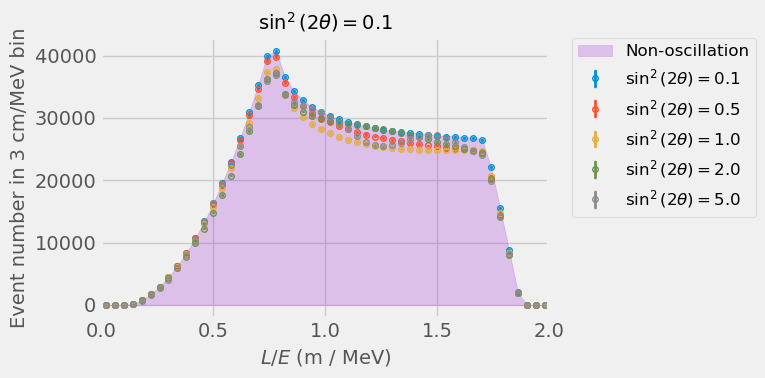

In [71]:
first_max_baseline = []
dm2_list = [0.1, 0.5, 1.0, 2.0, 5.0, 10]
for dm2 in dm2_list:
    bl = maximum_oscillation_energy_with_fixed_energy(dm2, 0.75, 0)
    first_max_baseline.append(bl)

fig, ax = plt.subplots(figsize=(8, 4))
dm2_list = [0.1, 0.5, 1.0, 2.0, 5.0]
sin_list = [0.01, 0.1, 0.5, 1.0]
#ax.errorbar(cents, Y_nonosc, yerr=Y_nonosc_err, fmt='s-', ms=4, capsize=1, lw=2, fillstyle='none', label='Non-oscillating')
ax.fill_between(cents, np.zeros(len(Y_nonosc)), Y_nonosc, alpha=0.2, color='darkviolet', label='Non-oscillation')
for means, stds in zip(Y_different_dm2, Y_different_dm2_err):
    ax.errorbar(cents, means, yerr=stds, fmt='o', ms=4, capsize=1, lw=2, fillstyle='none', label=r'$\sin^2(2\theta) = $' + str(dm2_list.pop(0)))
    #c1 = l1[0].get_color()
    #ax.vlines(first_max_baseline.pop(0), 0, 200, color=c1, linestyles='--')
ax.set_xlabel(r'$L/E$ (m / MeV)', fontsize=14)
ax.set_ylabel('Event number in 3 cm/MeV bin', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
ax.set_xlim(0, 2.0  )
#ax.set_ylim(100, 150)
#ax.set_title("Assuming 1e6 events in total")
#ax.set_title('mass split 1.0 eV^2', fontsize=15)
ax.set_title(r'$\sin^2(2\theta) = 0.1 $', fontsize=14)

plt.tight_layout()

plt.savefig('../plots/differentMassSplit_sin2thetasquare0.1_3cmbinwidth_absspec_1e6events.png')

/var/folders/7k/xd58zvd97t78ddgb1p89_p8h0000gn/T/ipykernel_51009/67455153.py:7: RuntimeWarning: invalid value encountered in divide
  l1 = ax.errorbar(cents, means/Y_nonosc, yerr=np.sqrt(stds**2+Y_nonosc_err**2)/Y_nonosc, fmt='o', ms=4, capsize=1, lw=2, fillstyle='none', label=r'$\sin^2(2\theta) = $' + str(dm2_list.pop(0)))


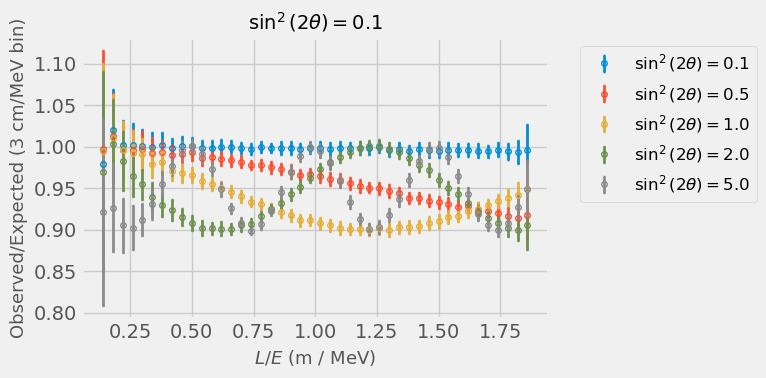

In [72]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(8, 4))
dm2_list = [0.1, 0.5, 1.0, 2.0, 5.0]
sin_list = [0.01, 0.1, 0.5, 1.0]
for means, stds in zip(Y_different_dm2, Y_different_dm2_err):
    l1 = ax.errorbar(cents, means/Y_nonosc, yerr=np.sqrt(stds**2+Y_nonosc_err**2)/Y_nonosc, fmt='o', ms=4, capsize=1, lw=2, fillstyle='none', label=r'$\sin^2(2\theta) = $' + str(dm2_list.pop(0)))
    #c1 = l1[0].get_color()
    #ax.vlines(first_max_baseline.pop(0), 0, 200, color=c1, linestyles='--')
# Only plot dm2=1.0eV2
#ax.errorbar(cents, Y_different_dm2[4]/Y_nonosc, yerr=np.sqrt(Y_different_dm2_err[4]**2)/Y_nonosc, fmt='o', ms=4, capsize=1, fillstyle='none', label=r'$\sin^2(2\theta) = 5.0$')
    
ax.set_xlabel(r'$L/E$ (m / MeV)', fontsize=13)
ax.set_ylabel('Observed/Expected (3 cm/MeV bin)', fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
#ax.set_xlim(0.1, 1.8  )
#ax.set_ylim(0.7, 1.3)
#ax.set_title("Assuming 1e6 events in total")
#ax.set_title('mass split 1.0 eV^2', fontsize=15)
ax.set_title(r'$\sin^2(2\theta) = 0.1 $', fontsize=14)
plt.tight_layout()

plt.savefig('../plots/differentMassSplit_sin2thetasquare0.1_3cmbinwidth_relspec_1e6events.png')